In [1]:
# The usual suspects
import pandas as pd
import random
import pickle
import math
import torch
import time
# Make sure torch.__version__>1.10

# Homemade librairies
from volume_interest import *
from tracking import *
from volume_reconstructor_em import *
from plots import *

# Classes tutorial

We create several classes to make the implementation of the algorithm easier. In this tutorial we will go through 3 of them:

- `volume_interest.py`
- `plots.py`
- `tracking.py`

## 1 - volume_interest.py: VolumeOfInterest Class

The **EM algorithm** implementation relies on a **voxelized volume of interest (VOI)**. As its name indicates, the `VolumeOfInterest` class is responsible for the modeling of the volume of interest and its voxelization. 

### Instantiation

When declaring an **instance** of `VolumeOfInterest`, one must provide **3 parameters**:

- `low_high_edges`: `([x_low,y_low,z_low], [x_high,y_high,z_high])` in m, representing repectivly the **bottom** and **upper** corner **of the VOI**.


- `n_vox_xyz`: `Tuple[int] = [Nx,Ny,Nz]` respectively the **number of voxels** along the x,y and z direction.


- `voxel_width`: `float` the **size of a voxel** in m. **Make sure that `(i_high - i_low)/voxel_width = Ni`**

If these parameters are not provided, default parameters corresponding to standard TomOpt VOI will be used. In case one wants a custom VOI, the `VolumeOfInterest` should be instancieted as follow:

In [2]:
import pickle
Lrad=torch.load('beryllium_lead.pt')
lrad_org=np.transpose(Lrad, (1, 2, 0))

with open('materials_radiation_length.pkl', 'rb') as f:
    matr_lrad_dict = pickle.load(f)
    
unique_lrad=torch.unique(lrad_org)
mat_names=""
for m in unique_lrad:
    mat_names=mat_names+matr_lrad_dict[round(float(m),4)]+"("+str(round(float(m),4)) +")" 
    mat_names=mat_names+" "
print("Material includes: ",mat_names)

Material includes:  Pb(0.0056) Be(0.3528) 


### Composite Material - Be and Pb VOI

In [3]:
voi = VolumeOfInterest()

xyz_min = [0, 0, 0.2] # in meters
xyz_max = [1, 1, 0.8] # in meters
n_vox_xyz = (10,10,6) 
voxel_width = 0.1 # in meters

voi = VolumeOfInterest(low_high_edges = (xyz_min,xyz_max), 
                       n_vox_xyz = n_vox_xyz,
                       voxel_width = voxel_width)

### Features

The `generate_voxels()` method will **generate a grid of voxels** based on the input parameters provided above, using the `compute_voxel_centers`. Features of the voxelized volume are:

 - `voxel_centers`: `torch.tensor()` with size `(Nx,Ny,Nz,3)`. It contains the $x,y,z$ position of the center of each voxel. The position of the center of the voxel with indices $ix,iy,iz$ is `voxel_centers[ix,iy,iz]`.
 
 
 
 - `voxel_edges`: `torch.tensor()` with size `(Nx,Ny,Nz,2,3)`. It contains the $x,y,z$ position of the lower left and upper righ corner of each voxel. The positions of the lower left and upper right corner of the voxel with indices $ix,iy,iz$ are respectively `voxel_centers[ix,iy,iz,0,:]` and `voxel_centers[ix,iy,iz,1,:]`. 
 
 

In [4]:
ix,iy,iz = 0,0,0

# Voxel centers
print('Voxel with indices {},{},{} is located at x,y,z = {}'.format(ix,iy,iz,voi.voxel_centers[ix,iy,iz].numpy()))

# Voxel edges
print('\nLower left corner of voxel with indices {},{},{} \nis located at x,y,z = {}'.format(ix,iy,iz,voi.voxel_edges[ix,iy,iz,0].numpy()))
print('\nUpper right corner of voxel with indices {},{},{} \nis located at x,y,z = {}'.format(ix,iy,iz,voi.voxel_edges[ix,iy,iz,1].numpy()))

Voxel with indices 0,0,0 is located at x,y,z = [0.05 0.05 0.75]

Lower left corner of voxel with indices 0,0,0 
is located at x,y,z = [0.  0.  0.7]

Upper right corner of voxel with indices 0,0,0 
is located at x,y,z = [0.1 0.1 0.8]


Now that the VOI is properly defined, we can have a look at it using the `plot_muon_track()` method (in `plot.py`). This method is designed to plot both the VOI and a given track but if `track` is none it only plots the VOI.

## 2 - tracking.py: Tracking Class

The EM algorithm will require the position of a muon every time it enters and exits a voxel. The **`Tracking` class** will handle all the **computations** related to the **tracks**, the **voxel triggering**, and **inputs** to the **EM algorithm**.

### Instantiation

 - `voi`: An instance of the `VolumeOfInterest` class.
 
 - `data`: `pandas.DataFrame`
 
 - `poca`: `bool` to indicate the choice of trajectory modelling approach: Single Line Assumption or Point of Closest Approach (PoCA)
 
The dataset we use contains the following features: 

In [5]:
data=pd.read_csv('10000muons_10000resolution_z5z6lead_5_5_POCA_1.csv')

#variables names must abide by variable names used in the code accesses to the data
data.rename(columns={"theta_xy_in_y":"theta_in_y",'theta_xy_in_x':'theta_in_x','theta_xy_out_x':'theta_out_x','theta_xy_out_y':'theta_out_y'},inplace=True)

data.columns

Index(['Unnamed: 0', 'theta_in_x', 'theta_in_y', 'theta_xy_in_unc_x',
       'theta_xy_in_unc_y', 'theta_out_x', 'theta_out_y', 'theta_xy_out_unc_x',
       'theta_xy_out_unc_y', 'xyz_in_x', 'xyz_in_y', 'xyz_in_z',
       'xyz_in_unc_x', 'xyz_in_unc_y', 'xyz_in_unc_z', 'xyz_out_x',
       'xyz_out_y', 'xyz_out_z', 'xyz_out_unc_x', 'xyz_out_unc_y',
       'xyz_out_unc_z', 'mom', 'location_x', 'location_y', 'location_z'],
      dtype='object')

In [6]:
start = time.time()

myTracks_slr=Tracking(voi,data,poca=False)
end = time.time()
run_time=round((end - start)/60,1)
print("Running time for computing tracks of trajectory within VOI for",len(data),"events:",run_time," minutes")

Computing inputs for the EM steps (W, L, T and M):


Computing inputs for the EM steps (Dx and Dy):


Running time for computing tracks of trajectory within VOI for 9980 events: 1.0  minutes


In [7]:
# tracks
layer = 0
event = 0
print('\nMuon #{} enters voxel layer {} at x,y,z = {},{},{}'.format(event,
                                                                 layer,
                                                                 myTracks_slr.tracks[0,layer,myTracks_slr.indices[event]].numpy(),
                                                                 myTracks_slr.tracks[1,layer,myTracks_slr.indices[event]].numpy(),
                                                                 myTracks_slr.tracks[2,layer,myTracks_slr.indices[event]].numpy()))
print('\nMuon #{} exits voxel layer {} at x,y,z = {},{},{}'.format(event,
                                                                 layer,
                                                                 myTracks_slr.tracks[0,layer+1,myTracks_slr.indices[event]].numpy(),
                                                                 myTracks_slr.tracks[1,layer+1,myTracks_slr.indices[event]].numpy(),
                                                                 myTracks_slr.tracks[2,layer+1,myTracks_slr.indices[event]].numpy()))

# triggered_voxels
print('\nMuon #{} triggers voxels with indices:\n {}'.format(event, myTracks_slr.triggered_voxels[event]))


Muon #0 enters voxel layer 0 at x,y,z = 0.9046624981099218,0.9242213047844551,0.800000011920929

Muon #0 exits voxel layer 0 at x,y,z = 0.9173465996667721,0.8921133675101842,0.699999988079071

Muon #0 triggers voxels with indices:
 [[9, 9, 0], [9, 8, 0], [9, 8, 1], [9, 8, 2], [9, 8, 3], [9, 7, 3], [9, 7, 4], [9, 7, 5]]


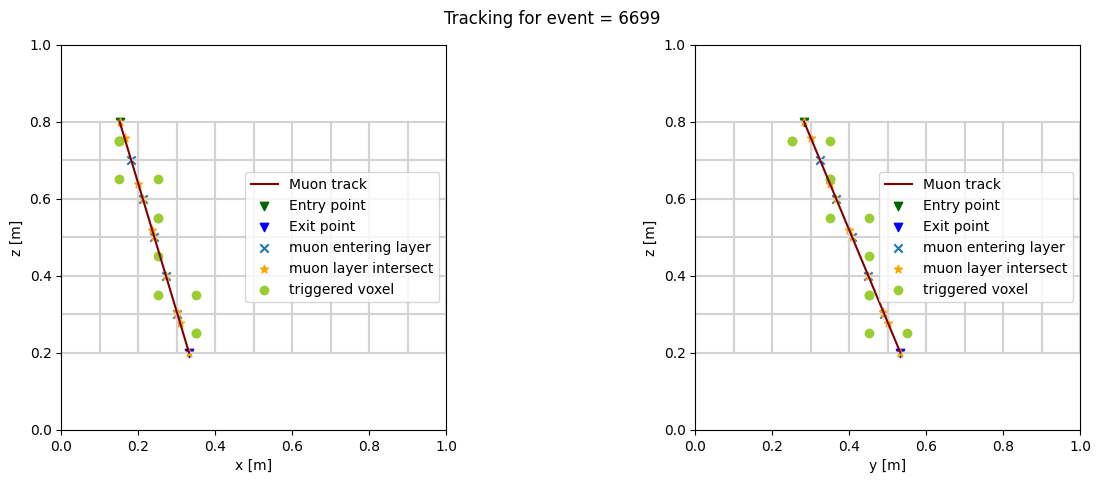

In [8]:
event=random.randint(0,len(myTracks_slr.triggered_voxels))
plot_discrete_track_2d(VOI=voi, tracking=myTracks_slr, event = event)

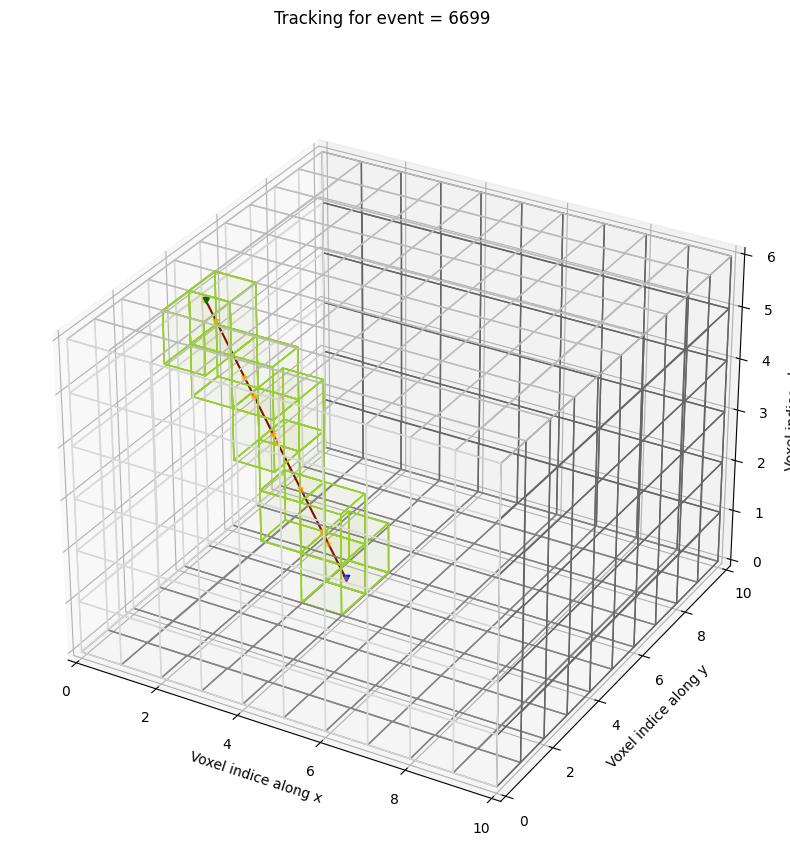

In [9]:
%matplotlib inline
plot_discrete_track_3d(VOI=voi, tracking=myTracks_slr, event = event)

## 3 - volume_reconstructor_em.py: VolumeReconstructorEM Class

The VolumeReconstructorEM class uses the attributes generated by the Tracking class to execute equations in the course of the expectation (E) and maximization (M) steps.

### Instantiation

 - `voi`: An instance of the `VolumeOfInterest` class.
 
 - `data`: `pandas.DataFrame`
 
 - `em_iter`: an integer representing the number of iterations for the expectation-maximization (EM) algorithm

 - `init_lrad`: a float representing the initial radiation length for the VOI. Default value = 0.5m


In [10]:
start = time.time()

em_reconstruct_slr=VolumeReconstructorEM(voi, myTracks_slr, data, em_iter=30)

end = time.time()
run_time=round((end - start)/60,1)
print("Running time for prediction of VOI material using",len(data),"events:",run_time," minutes")

Performing the Expectation and Maximization (EM) steps:


Running time for prediction of VOI material using 9980 events: 4.8  minutes


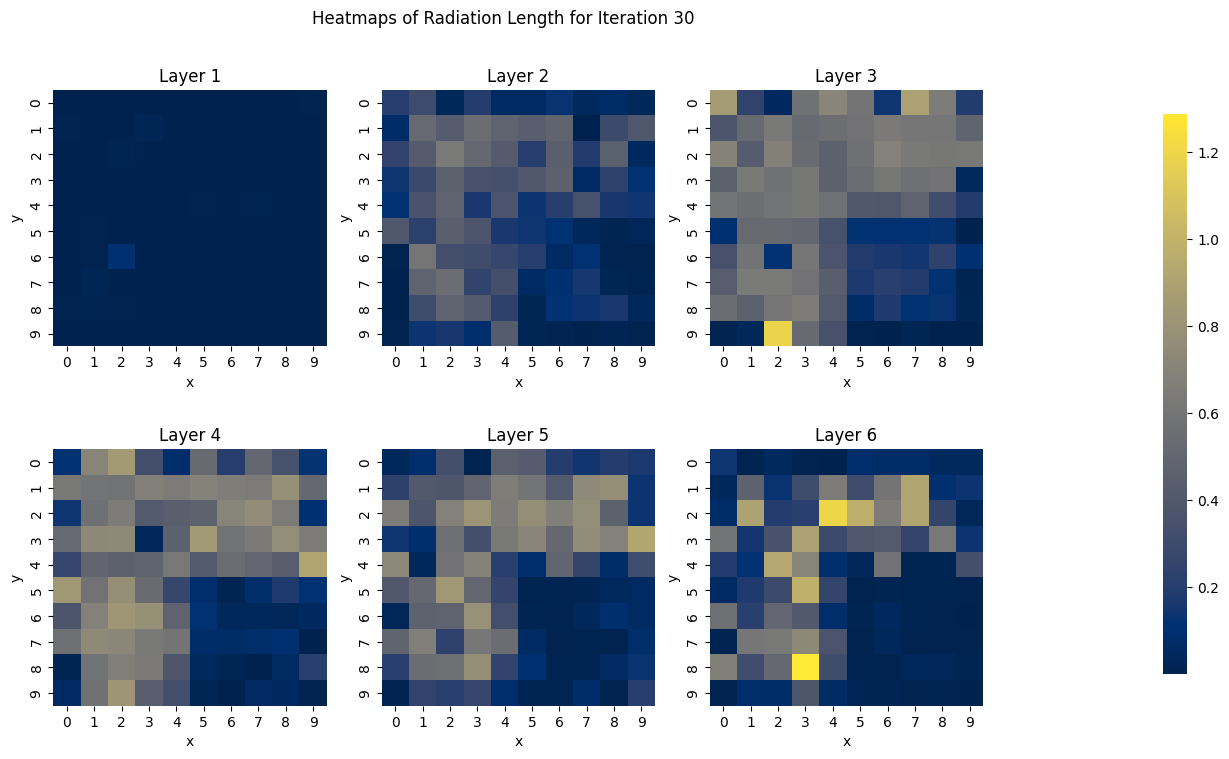

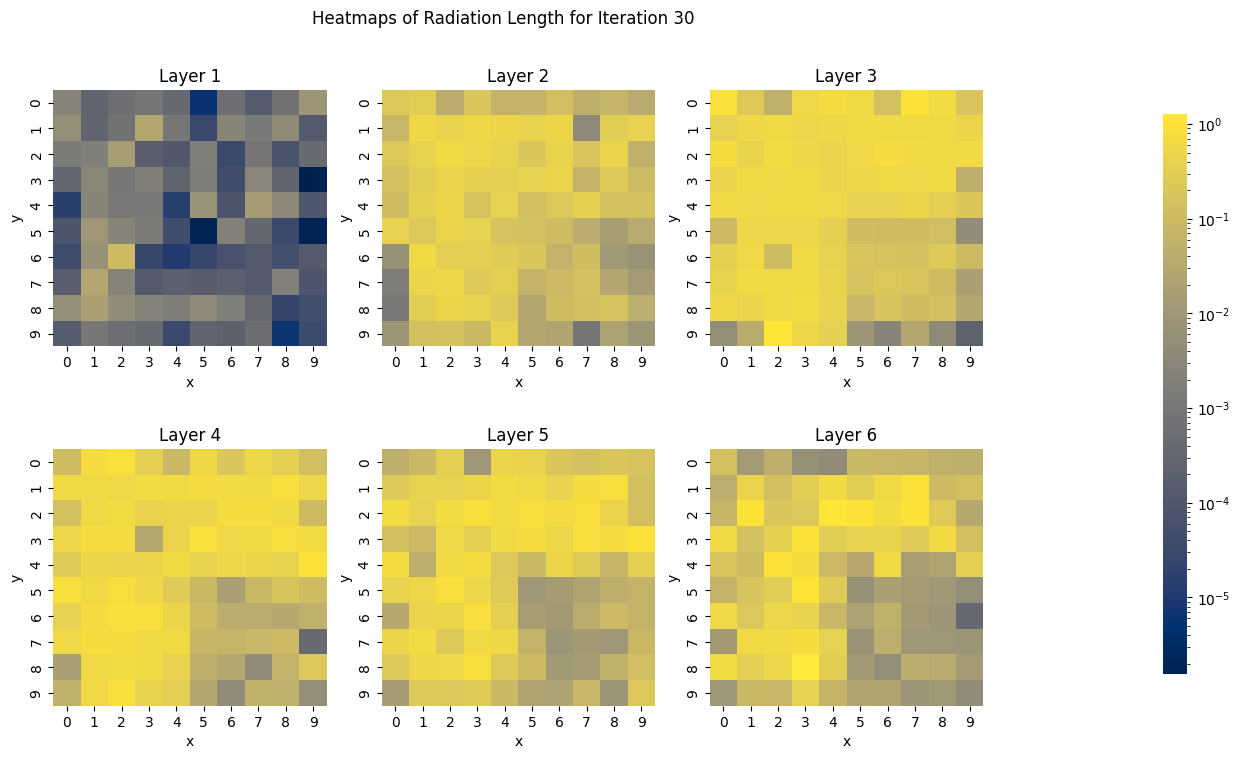

Layer 1: 0.1223748
Layer 2: 0.0473699
Layer 3: 0.0497677
Layer 4: 0.0603288
Layer 5: 0.0729460
Layer 6: 0.1044325


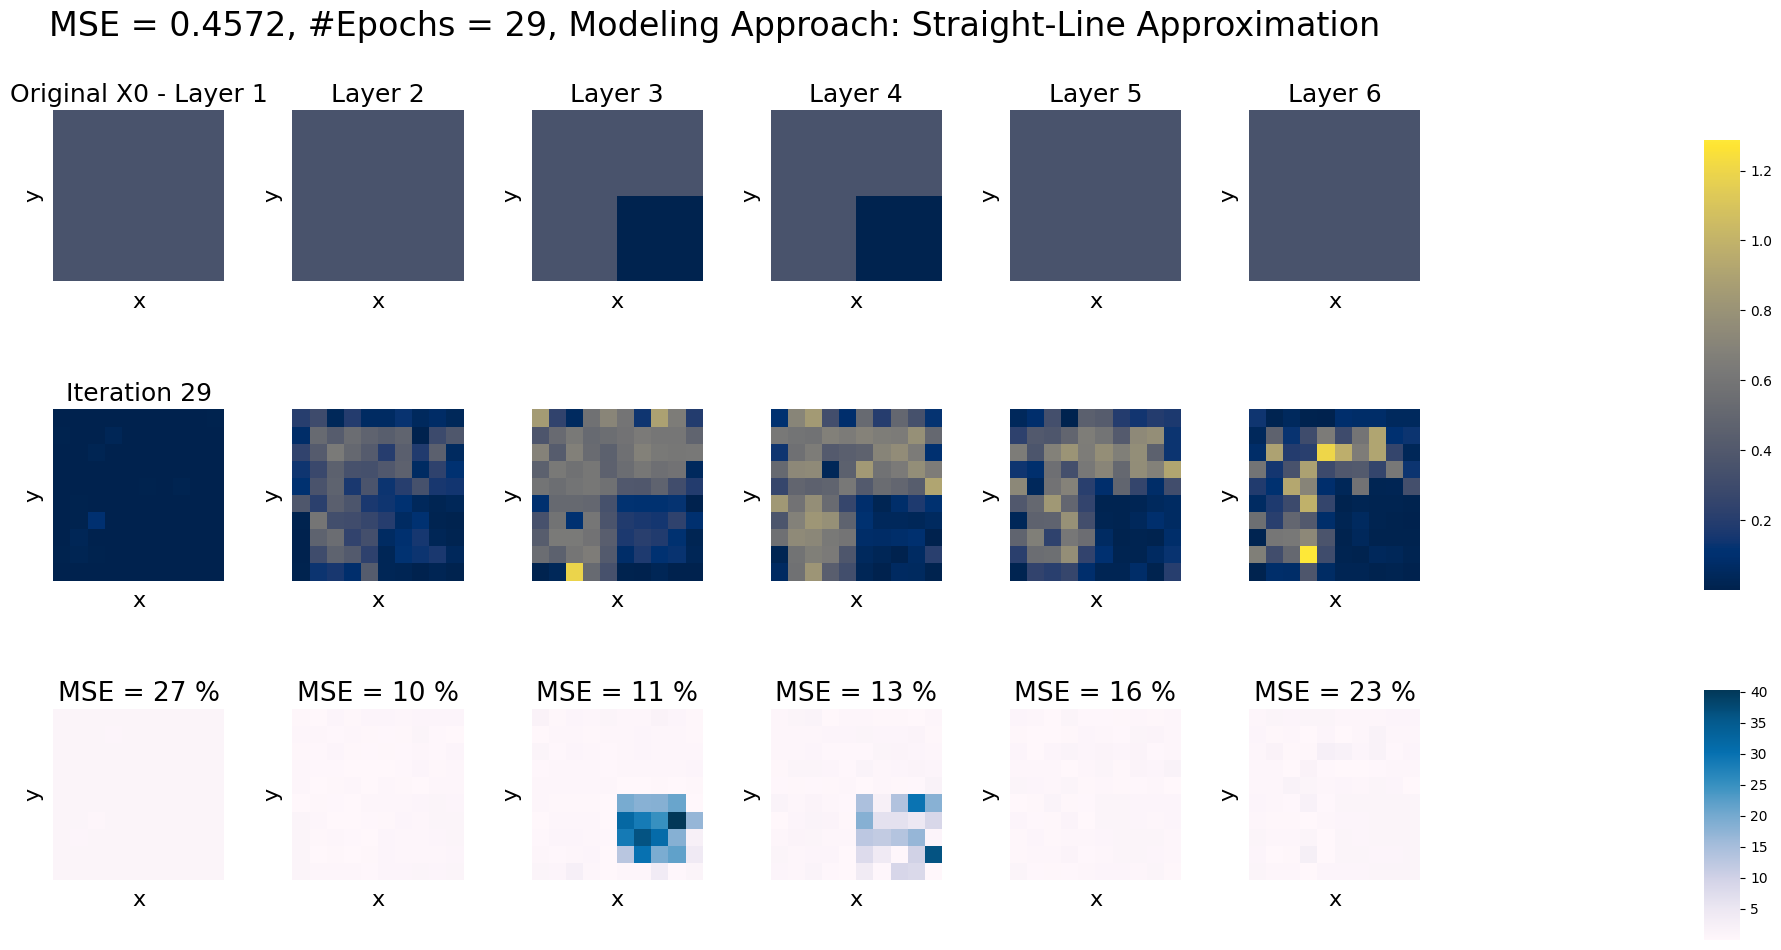

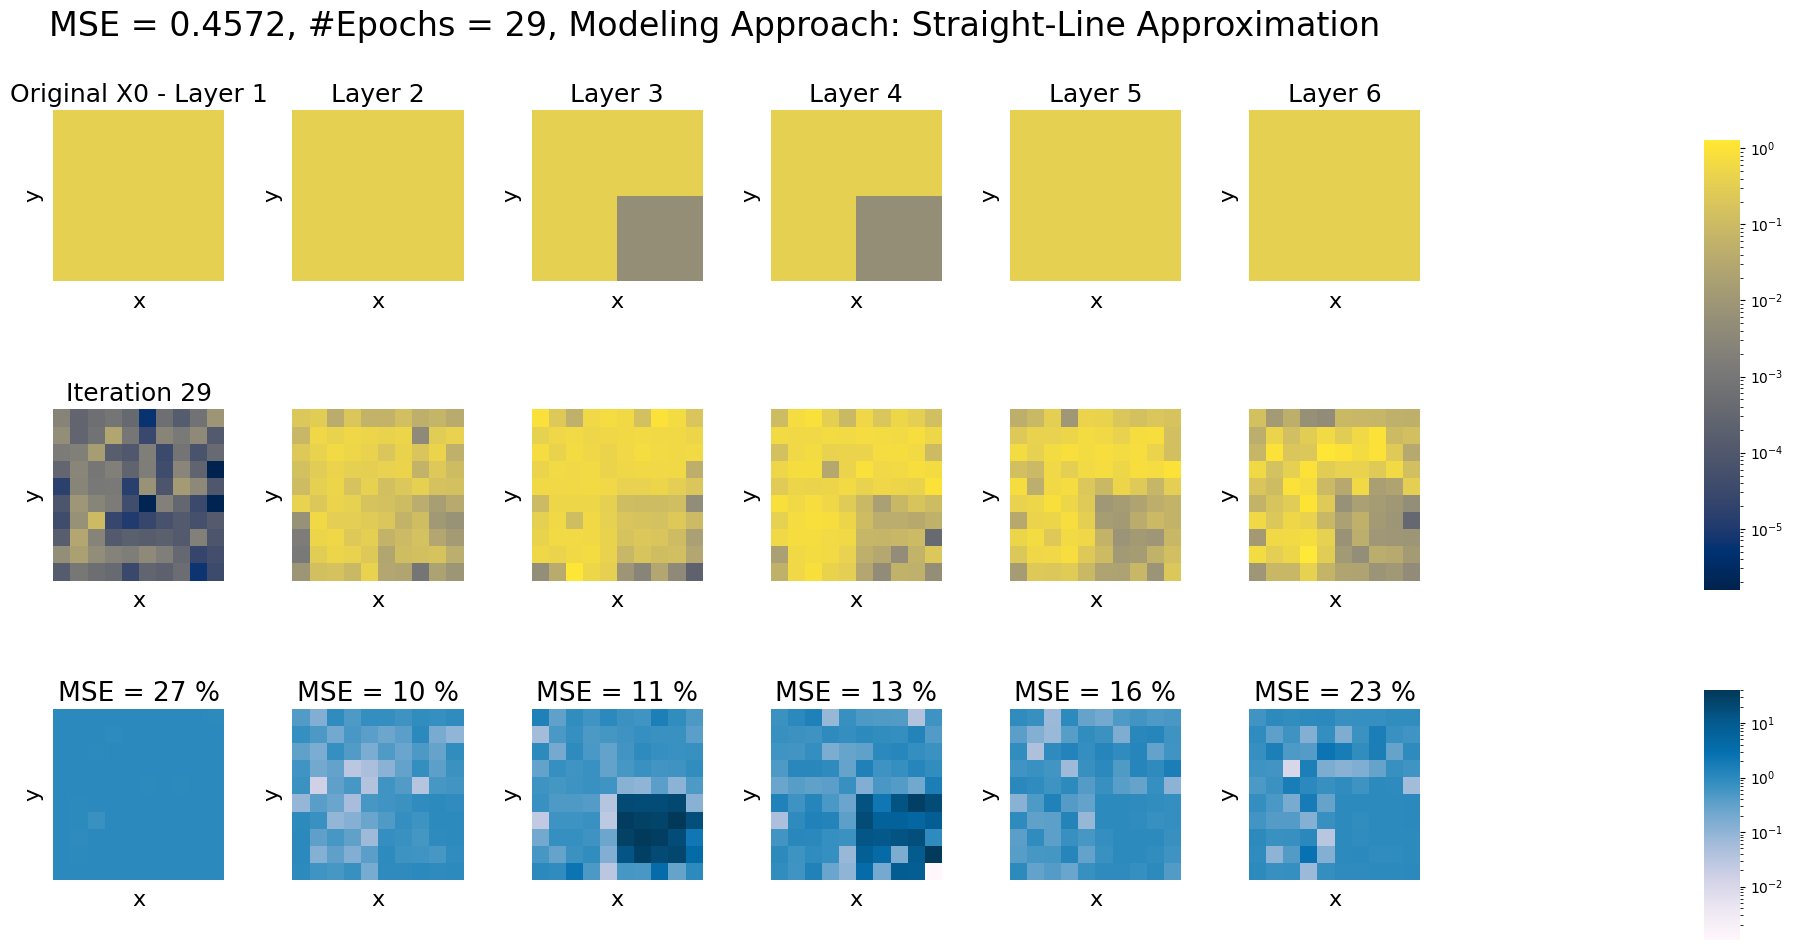

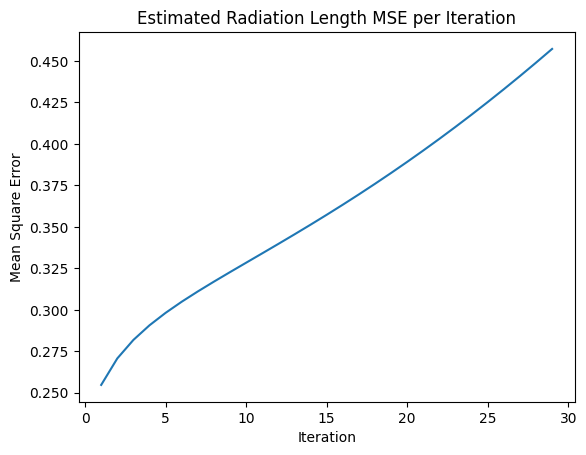

In [11]:
poca='PoCA'
slr='Straight-Line Approximation'
itermax=em_reconstruct_slr.em_iter-1
reconstr=em_reconstruct_slr

plot_event_lrad_heatmaps(reconstr.rad_length[itermax],itermax,False,False)
plot_event_lrad_heatmaps(reconstr.rad_length[itermax],itermax,True,False)

lrad_distrb=radiation_distribution(reconstr.rad_length,lrad_org,itermax) 
lrad_reconstr=reconstr.rad_length[itermax]

mse=compute_mse(lrad_reconstr,lrad_org)    
mse_total=sum(mse)


lrad=abs_diff_ratio(lrad_reconstr,lrad_org)

plot_lrad_across_iter(itermax, reconstr.rad_length[itermax],lrad_org, lrad,False,mse,mse_total, slr)
plot_lrad_across_iter(itermax, reconstr.rad_length[itermax],lrad_org, lrad,True,mse,mse_total, slr)

plot_mse_per_iteration(reconstr,lrad_org,0,per_layer=False,itermax=itermax)


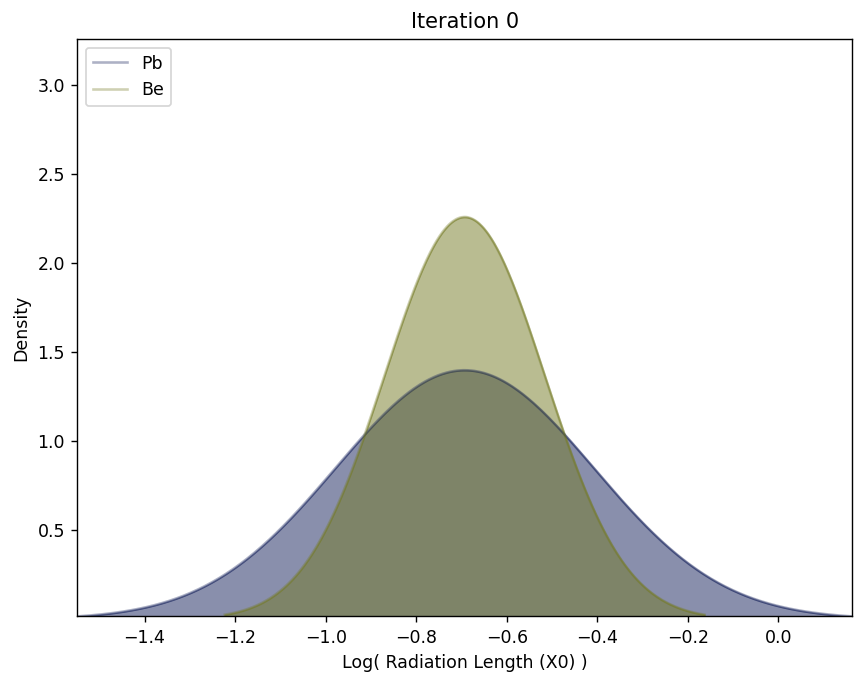

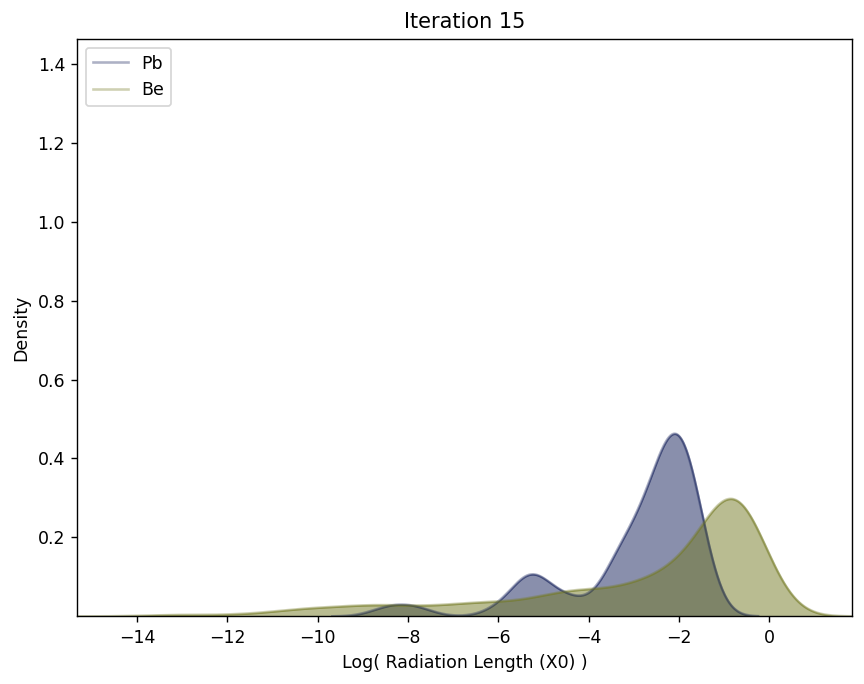

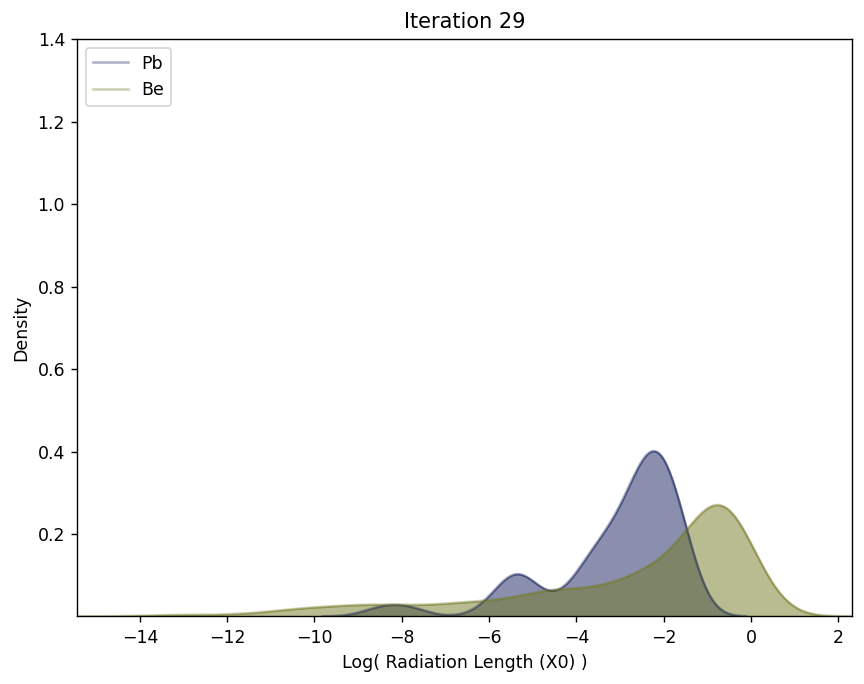

In [12]:
reconstr=em_reconstruct_slr
lrad_distrb_composite_mtr=radiation_distribution(reconstr.rad_length,lrad_org,reconstr.em_iter) 
rand_colors=generate_distinct_hex_colors(len(unique_lrad))
matr_lrad2, x_lim2, y_lim2 = compute_density(lrad_distrb_composite_mtr,reconstr.em_iter,True)
plot_density_for_lrad(matr_lrad2, x_lim2, y_lim2,0,rand_colors,True)
plot_density_for_lrad(matr_lrad2, x_lim2, y_lim2,int(reconstr.em_iter/2),rand_colors,True)
plot_density_for_lrad(matr_lrad2, x_lim2, y_lim2,reconstr.em_iter-1,rand_colors,True)

### PoCA Trajectory Modelling Approach

In [13]:
start = time.time()

myTracks_poca=Tracking(voi,data,poca=True)
end = time.time()
run_time=round((end - start)/60,1)
print("Running time for computing tracks of trajectory within VOI for",len(data),"events:",run_time," minutes")

Computing inputs for the EM steps (W, L, T and M):


Computing inputs for the EM steps (Dx and Dy):


Running time for computing tracks of trajectory within VOI for 9980 events: 1.7  minutes


In [14]:
start = time.time()

em_reconstruct_poca=VolumeReconstructorEM(voi, myTracks_poca, data, em_iter=30)

end = time.time()
run_time=round((end - start)/60,1)
print("Running time for prediction of VOI material using",len(data),"events:",run_time," minutes")

Performing the Expectation and Maximization (EM) steps:


Running time for prediction of VOI material using 9980 events: 5.1  minutes


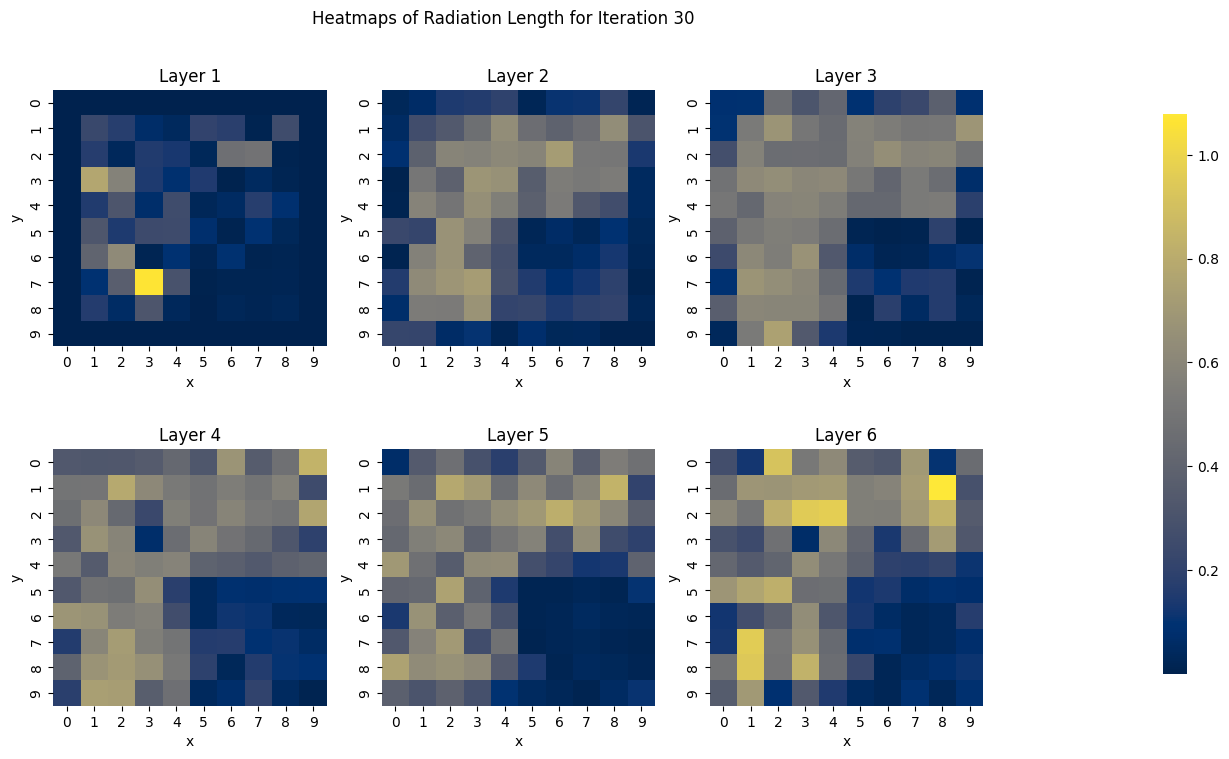

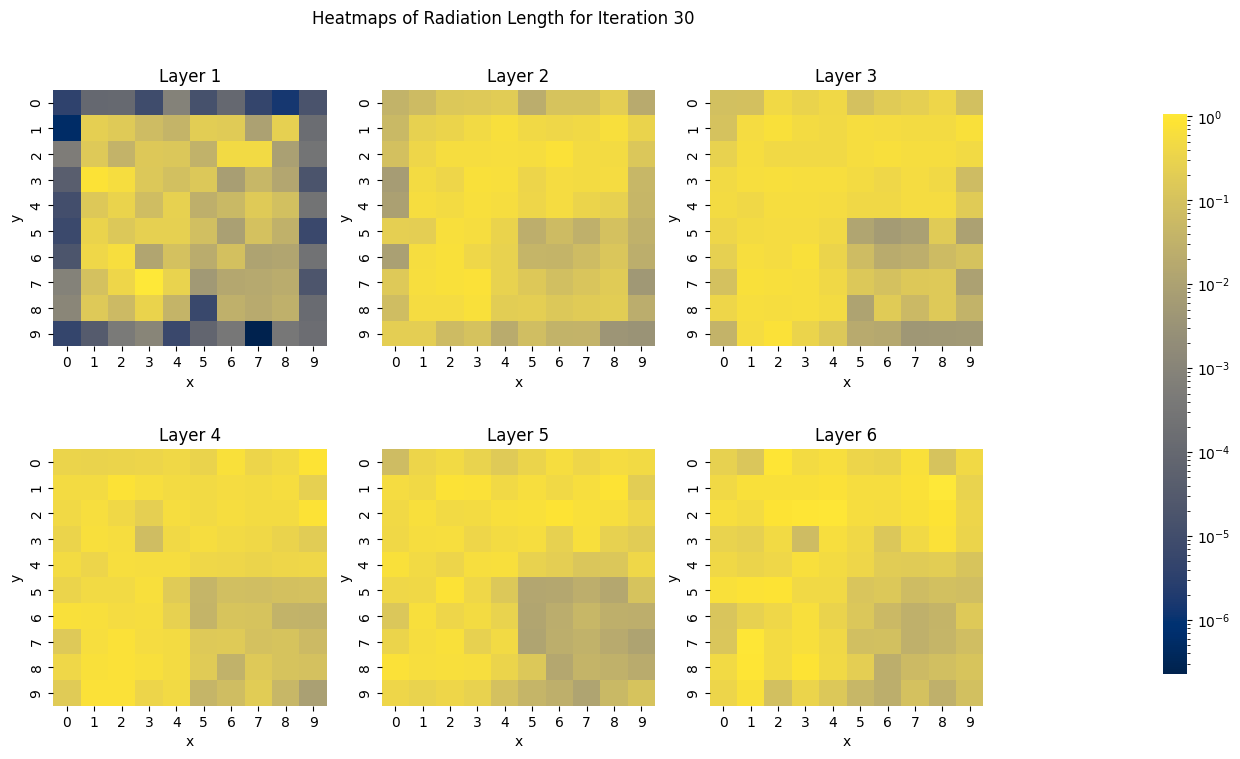

Layer 1: 0.0931187
Layer 2: 0.0582651
Layer 3: 0.0326293
Layer 4: 0.0345763
Layer 5: 0.0606587
Layer 6: 0.0800760


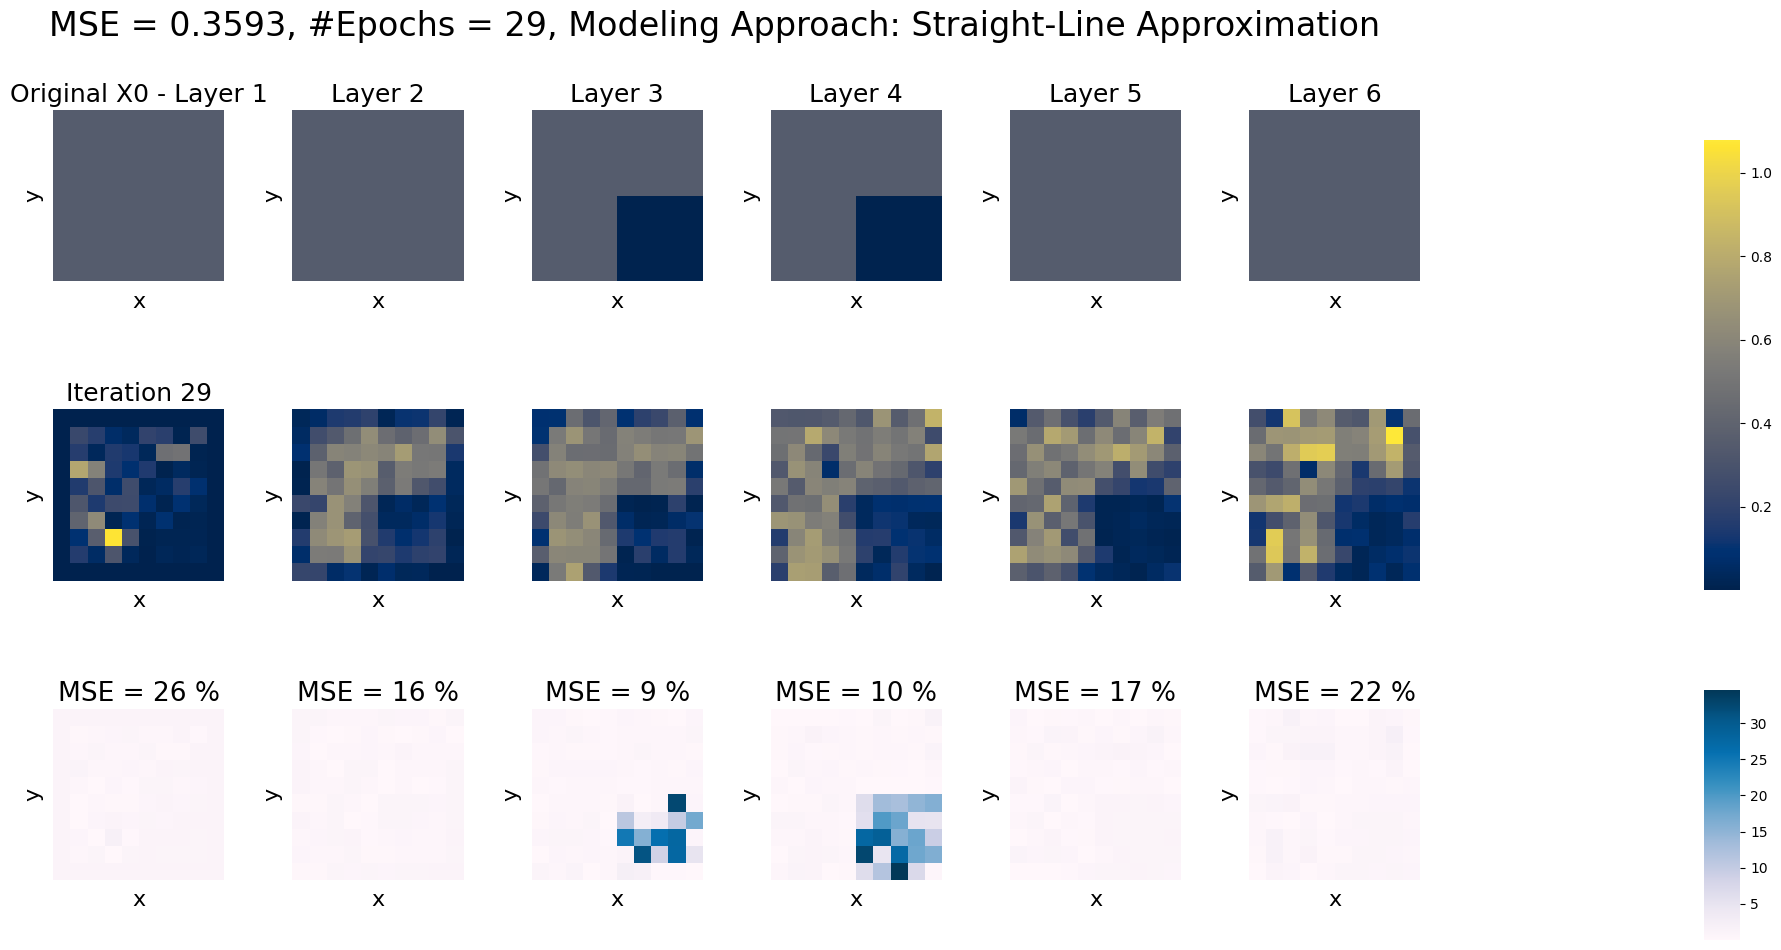

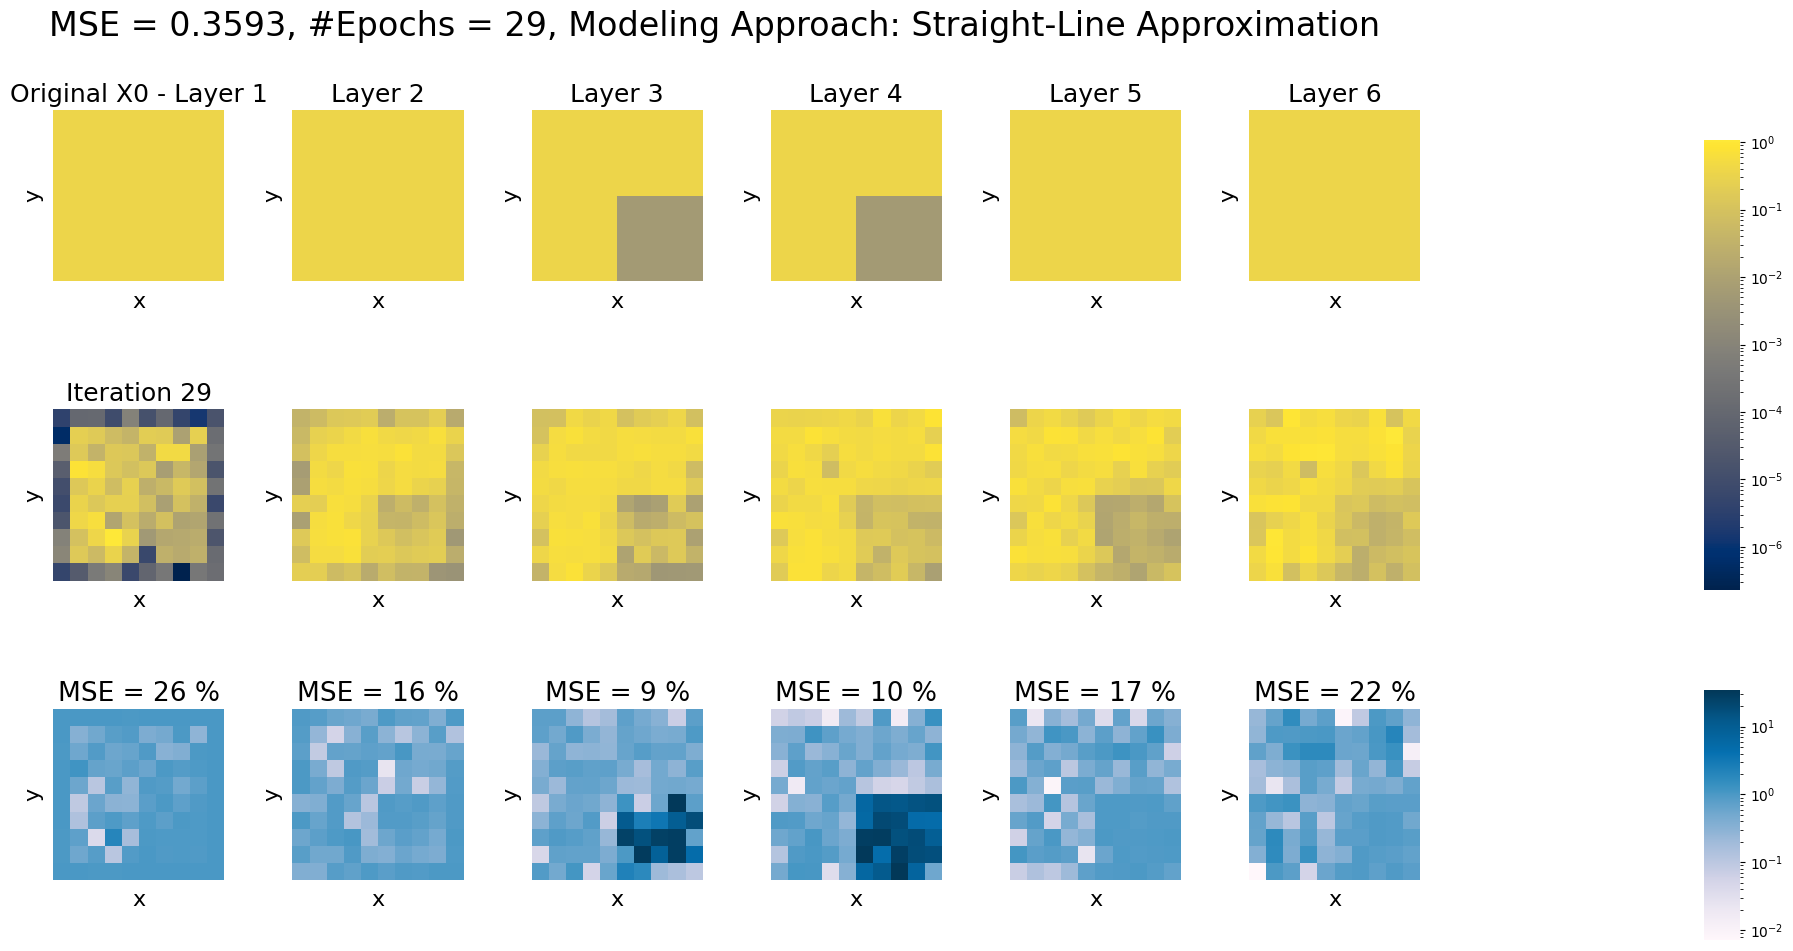

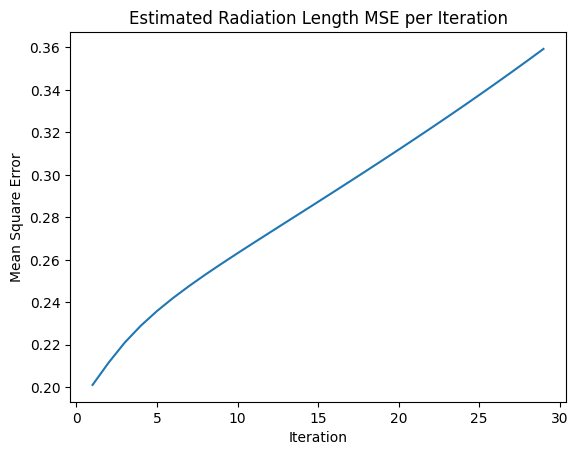

In [15]:
itermax=em_reconstruct_poca.em_iter-1
reconstr=em_reconstruct_poca

plot_event_lrad_heatmaps(reconstr.rad_length[itermax],itermax,False,False)
plot_event_lrad_heatmaps(reconstr.rad_length[itermax],itermax,True,False)

lrad_distrb=radiation_distribution(reconstr.rad_length,lrad_org,itermax) 
lrad_reconstr=reconstr.rad_length[itermax]

mse=compute_mse(lrad_reconstr,lrad_org)    
mse_total=sum(mse)


lrad=abs_diff_ratio(lrad_reconstr,lrad_org)

plot_lrad_across_iter(itermax, reconstr.rad_length[itermax],lrad_org, lrad,False,mse,mse_total, slr)
plot_lrad_across_iter(itermax, reconstr.rad_length[itermax],lrad_org, lrad,True,mse,mse_total, slr)

plot_mse_per_iteration(reconstr,lrad_org,0,per_layer=False,itermax=itermax)


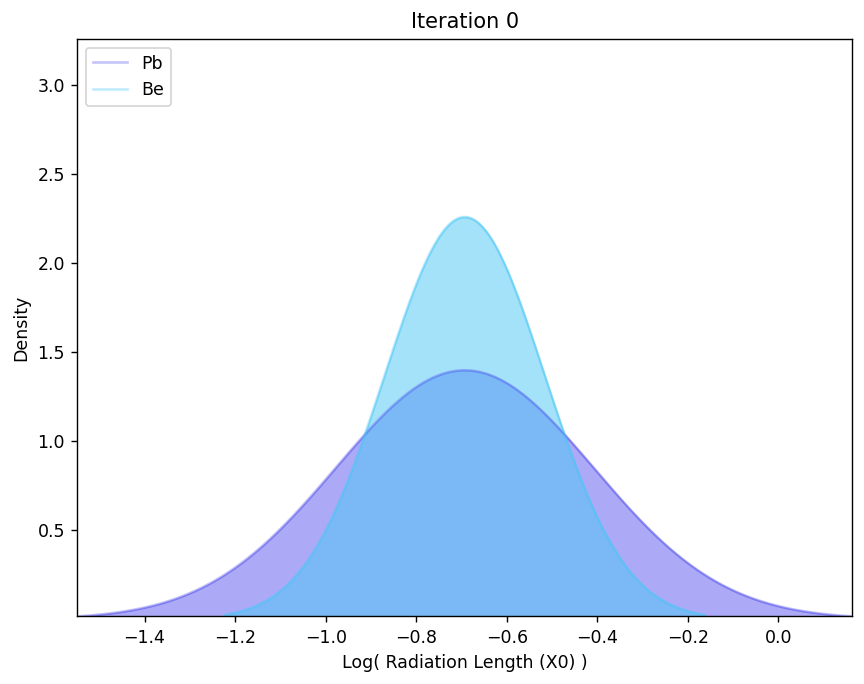

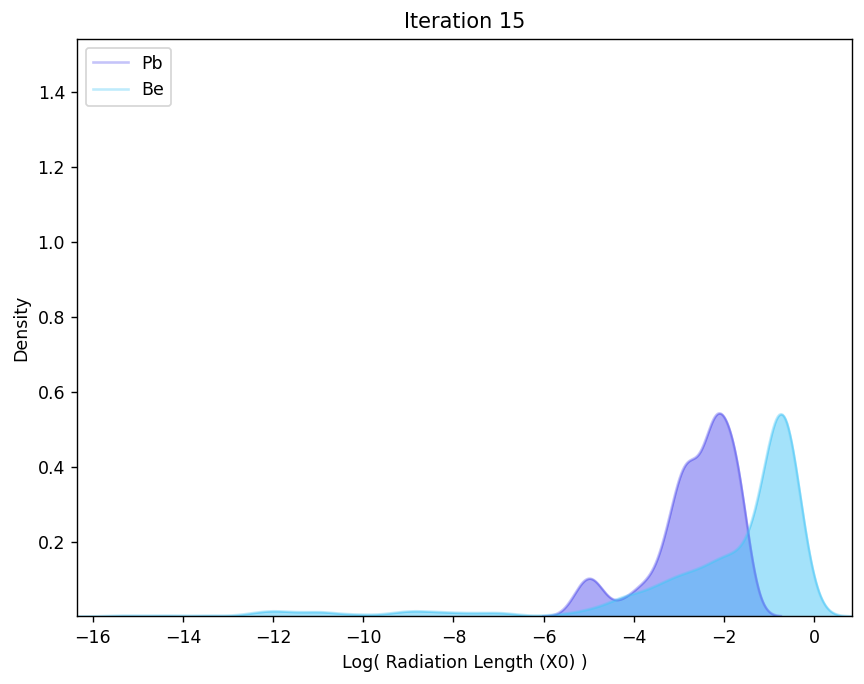

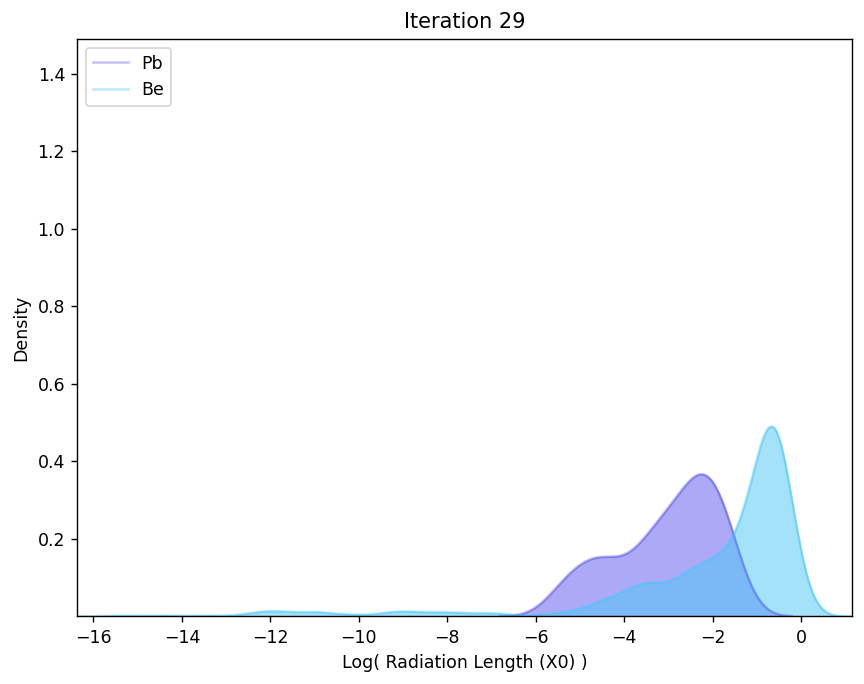

In [16]:
reconstr=em_reconstruct_poca
lrad_distrb_composite_mtr=radiation_distribution(reconstr.rad_length,lrad_org,reconstr.em_iter) 
rand_colors=generate_distinct_hex_colors(len(unique_lrad))
matr_lrad2, x_lim2, y_lim2 = compute_density(lrad_distrb_composite_mtr,reconstr.em_iter,True)
plot_density_for_lrad(matr_lrad2, x_lim2, y_lim2,0,rand_colors,True)
plot_density_for_lrad(matr_lrad2, x_lim2, y_lim2,int(reconstr.em_iter/2),rand_colors,True)
plot_density_for_lrad(matr_lrad2, x_lim2, y_lim2,reconstr.em_iter-1,rand_colors,True)

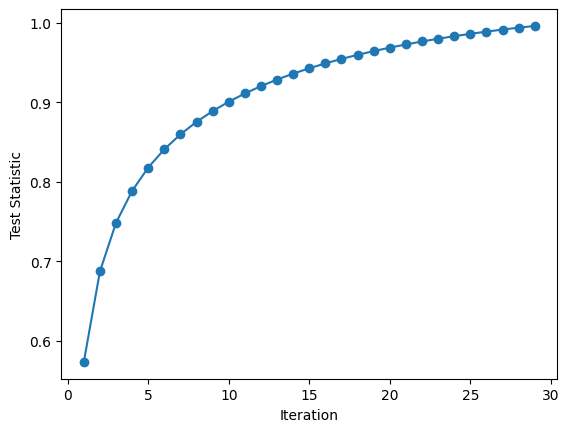

In [17]:
myTracks_bepb=em_reconstruct_poca
stat_test_case_study(myTracks_bepb)

## Mono-material - Al VOI - GEANT4 Data 

In [18]:
import pickle
Lrad=torch.load('aluminium.pt')
lrad_org=np.transpose(Lrad, (1, 2, 0))

with open('materials_radiation_length.pkl', 'rb') as f:
    matr_lrad_dict = pickle.load(f)
    
unique_lrad=torch.unique(lrad_org)
mat_names=""
for m in unique_lrad:
    mat_names=mat_names+matr_lrad_dict[round(float(m),4)]+"("+str(round(float(m),4)) +")" 
    mat_names=mat_names+" "
print("Material includes: ",mat_names)

Material includes:  Al(0.089) 


In [19]:
data = pd.read_csv('Aluminum_block_100k_event_in_VOI_only.csv')
print(data.shape)
print(data.columns)

#Momentum must be in GeV
data['mom']=data['E'].apply(momentum_from_kinetic_E)

#variables names must abide by variable names used in the code accesses to the data
data.rename(columns={'theta_x_in':'theta_in_x','theta_y_in':'theta_in_y','theta_x_out':'theta_out_x','theta_y_out':'theta_out_y','x_poca':'location_x', 'y_poca':'location_y', 'z_poca':'location_z', 'x_in':'xyz_in_x', 'y_in':'xyz_in_y', 'z_in':'xyz_in_z', 'x_out':'xyz_out_x', 'y_out':'xyz_out_y',
       'z_out':'xyz_out_z'},inplace=True)
data[['location_x', 'location_y', 'location_z', 'xyz_in_x', 'xyz_in_y','xyz_in_z', 'xyz_out_x','xyz_out_y','xyz_out_z']] = data[['location_x', 'location_y', 'location_z', 'xyz_in_x', 'xyz_in_y','xyz_in_z', 'xyz_out_x','xyz_out_y','xyz_out_z']] / 1000

# data
print("Mean energy = ",data['E'].mean(), "MeV")
print("Mean momentum = ",data['mom'].mean(), "GeV")

data_sample=data[0:5000]

(42702, 16)
Index(['theta_in', 'theta_out', 'theta_x_in', 'theta_x_out', 'theta_y_in',
       'theta_y_out', 'E', 'x_poca', 'y_poca', 'z_poca', 'x_in', 'y_in',
       'z_in', 'x_out', 'y_out', 'z_out'],
      dtype='object')
Mean energy =  5604.717162842489 MeV
Mean momentum =  5.707305035678231 GeV


In [20]:
position=[0,0,0.55]
dimension=[1,1,0.6]

xyz_min = get_boundaries(dimension,position,_min_=True) 
xyz_max = get_boundaries(dimension,position)
n_vox_xyz = (10,10,6) 
voxel_width = 0.1 


voi = VolumeOfInterest(low_high_edges = (xyz_min,xyz_max), 
                       n_vox_xyz = n_vox_xyz,
                       voxel_width = voxel_width)

In [21]:
start = time.time()
myTracks_al_geant4=Tracking(voi,data_sample,poca=False) 
end = time.time()
run_time=round((end - start)/60,1)
print("Running time for prediction of VOI material using",len(data_sample),"events:",run_time," minutes")


Computing inputs for the EM steps (W, L, T and M):


Computing inputs for the EM steps (Dx and Dy):


Running time for prediction of VOI material using 5000 events: 0.6  minutes


In [22]:
start = time.time()

em_reconstruct_geant4=VolumeReconstructorEM(voi, myTracks_al_geant4, data_sample, em_iter=30)

end = time.time()
run_time=round((end - start)/60,1)
print("Running time for prediction of VOI material using",len(data_sample),"events:",run_time," minutes")

Performing the Expectation and Maximization (EM) steps:


Running time for prediction of VOI material using 5000 events: 2.9  minutes


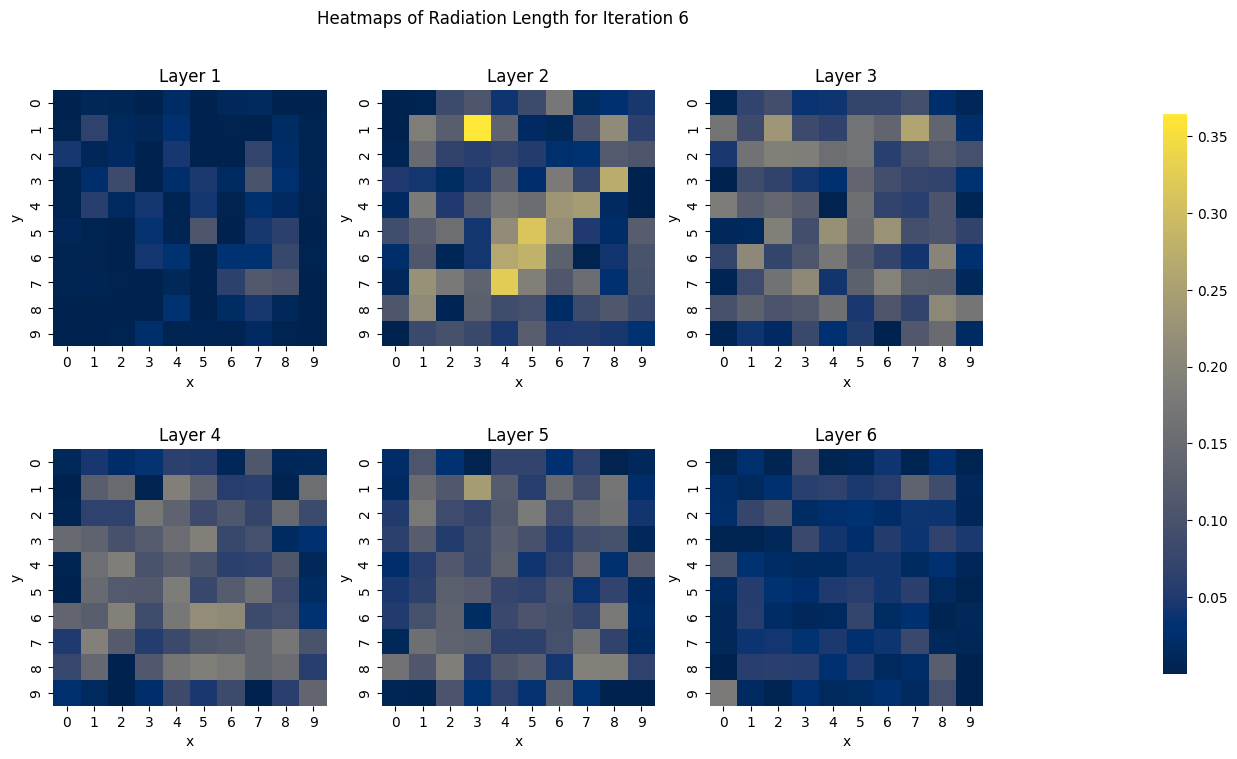

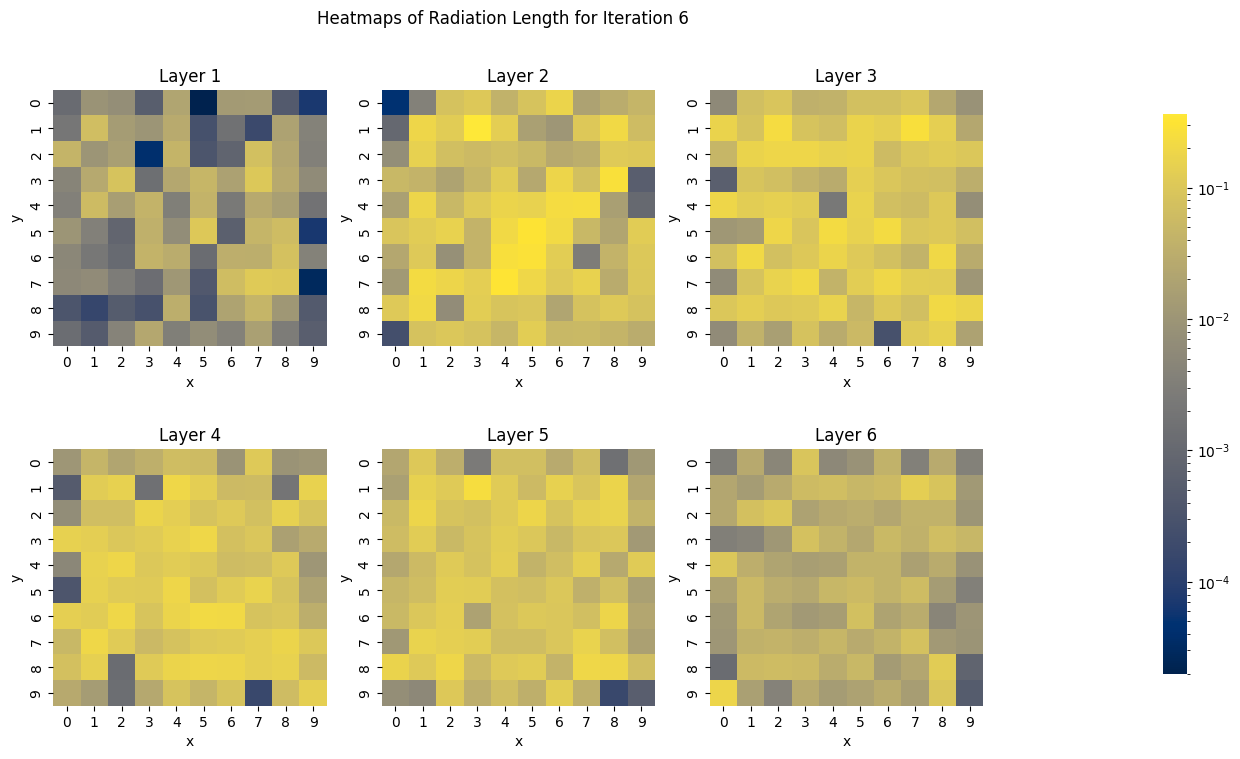

Layer 1: 0.0055332
Layer 2: 0.0067635
Layer 3: 0.0041103
Layer 4: 0.0035478
Layer 5: 0.0028575
Layer 6: 0.0038258


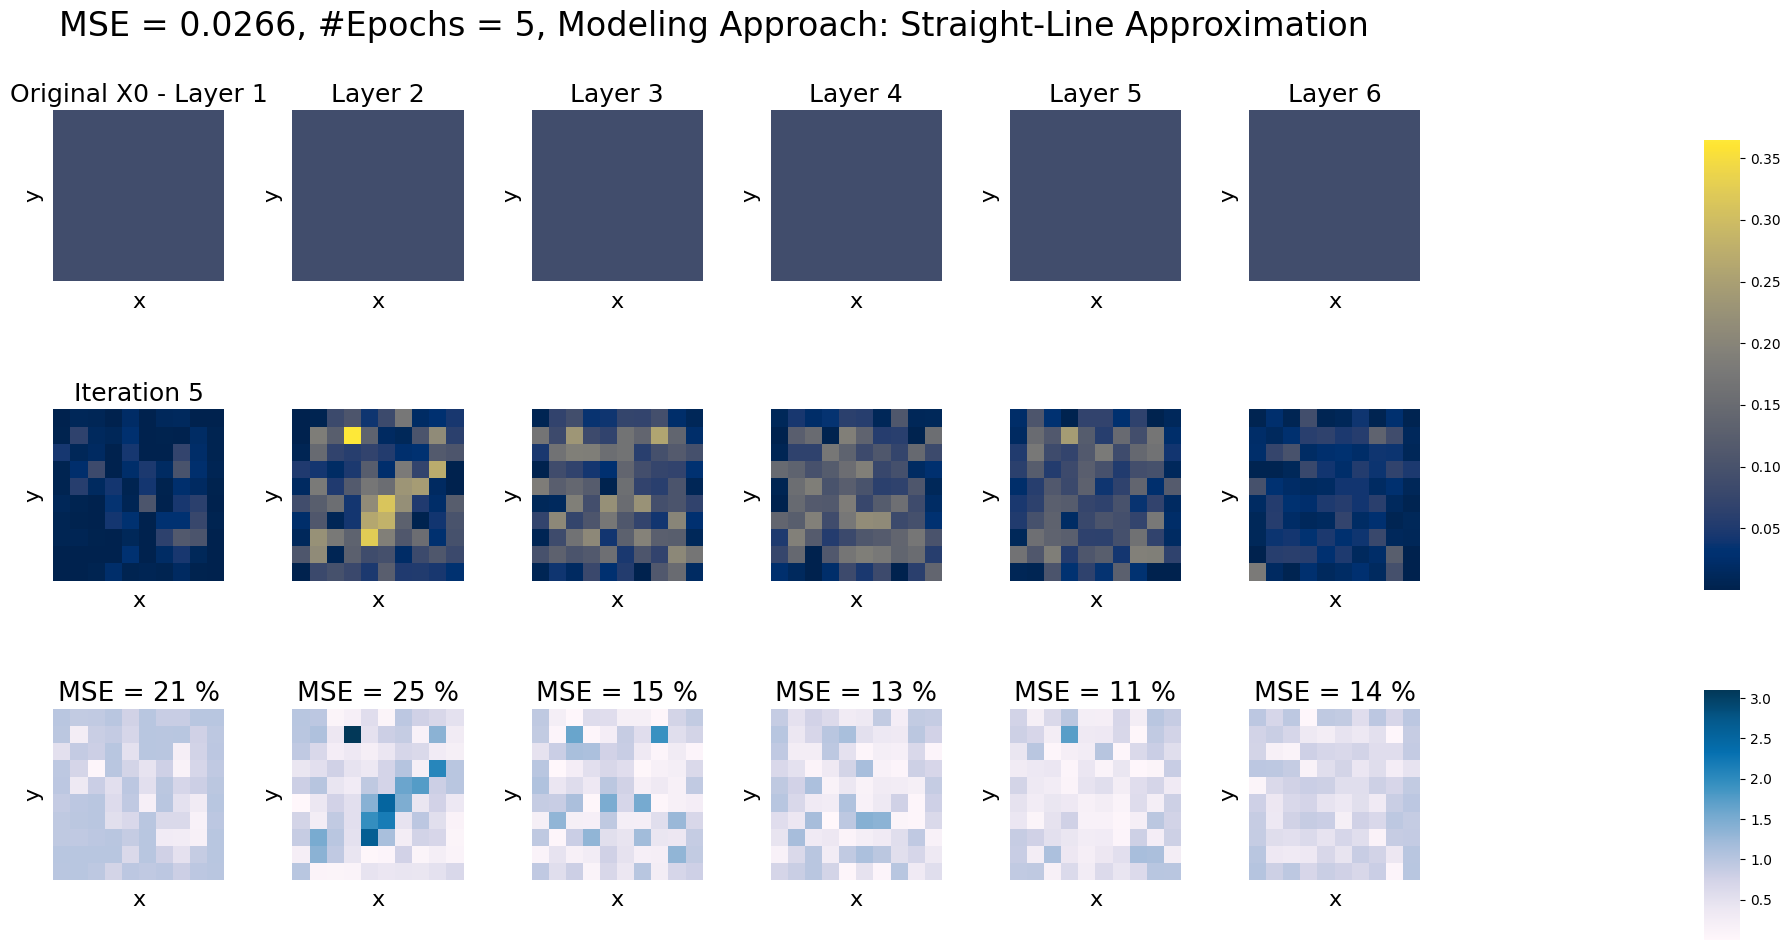

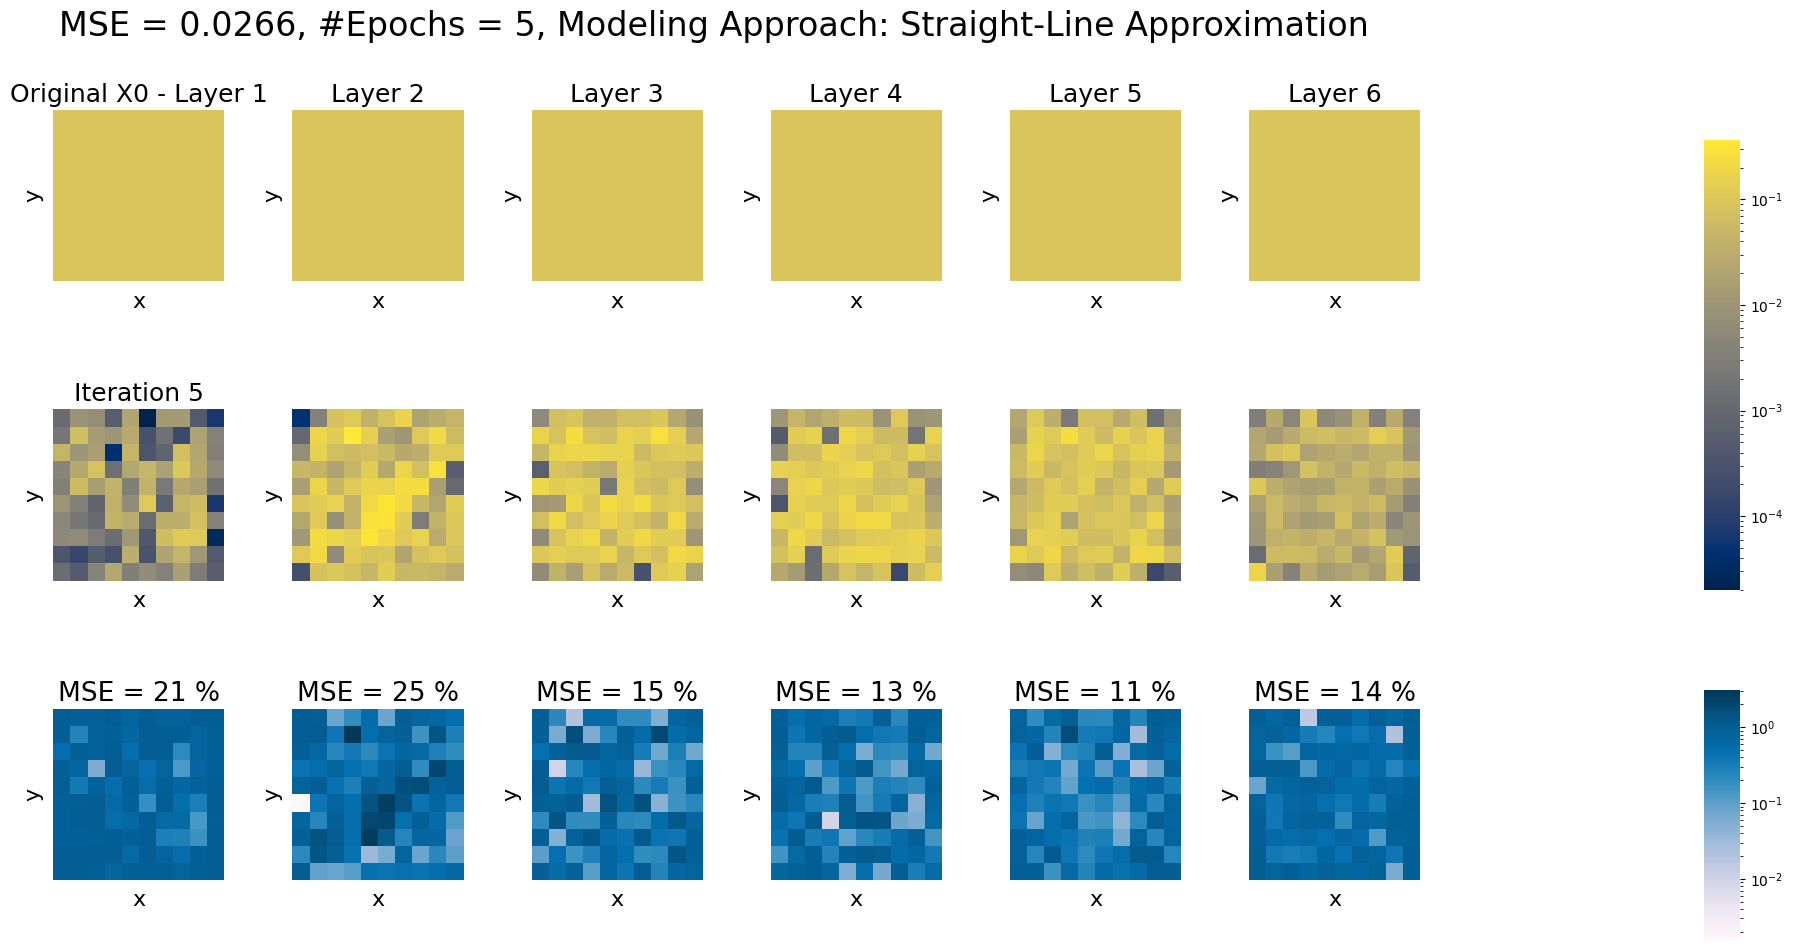

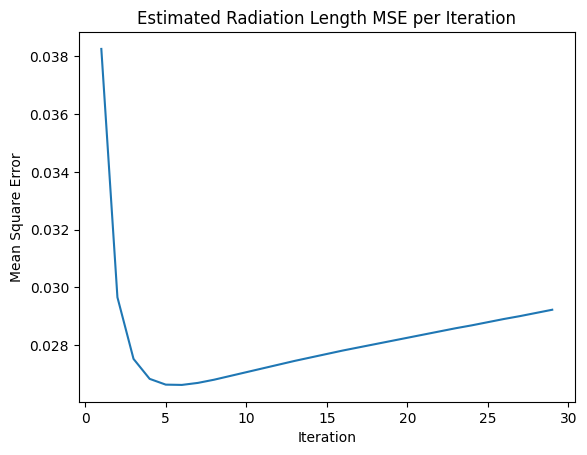

In [23]:
reconstr=em_reconstruct_geant4
_iter_=5


plot_event_lrad_heatmaps(reconstr.rad_length[_iter_],_iter_, False, False)
plot_event_lrad_heatmaps(reconstr.rad_length[_iter_],_iter_, True, False)


lrad_reconstr=reconstr.rad_length[_iter_]

mse=compute_mse(reconstr.rad_length[_iter_],lrad_org)
mse_total=sum(mse)


lrad=abs_diff_ratio(lrad_reconstr,lrad_org)

plot_lrad_across_iter(_iter_, reconstr.rad_length[_iter_],lrad_org, lrad,False,mse,mse_total,slr)
plot_lrad_across_iter(_iter_, reconstr.rad_length[_iter_],lrad_org, lrad,True,mse,mse_total,slr)

plot_mse_per_iteration(reconstr,lrad_org,0,per_layer=False,itermax=reconstr.em_iter)


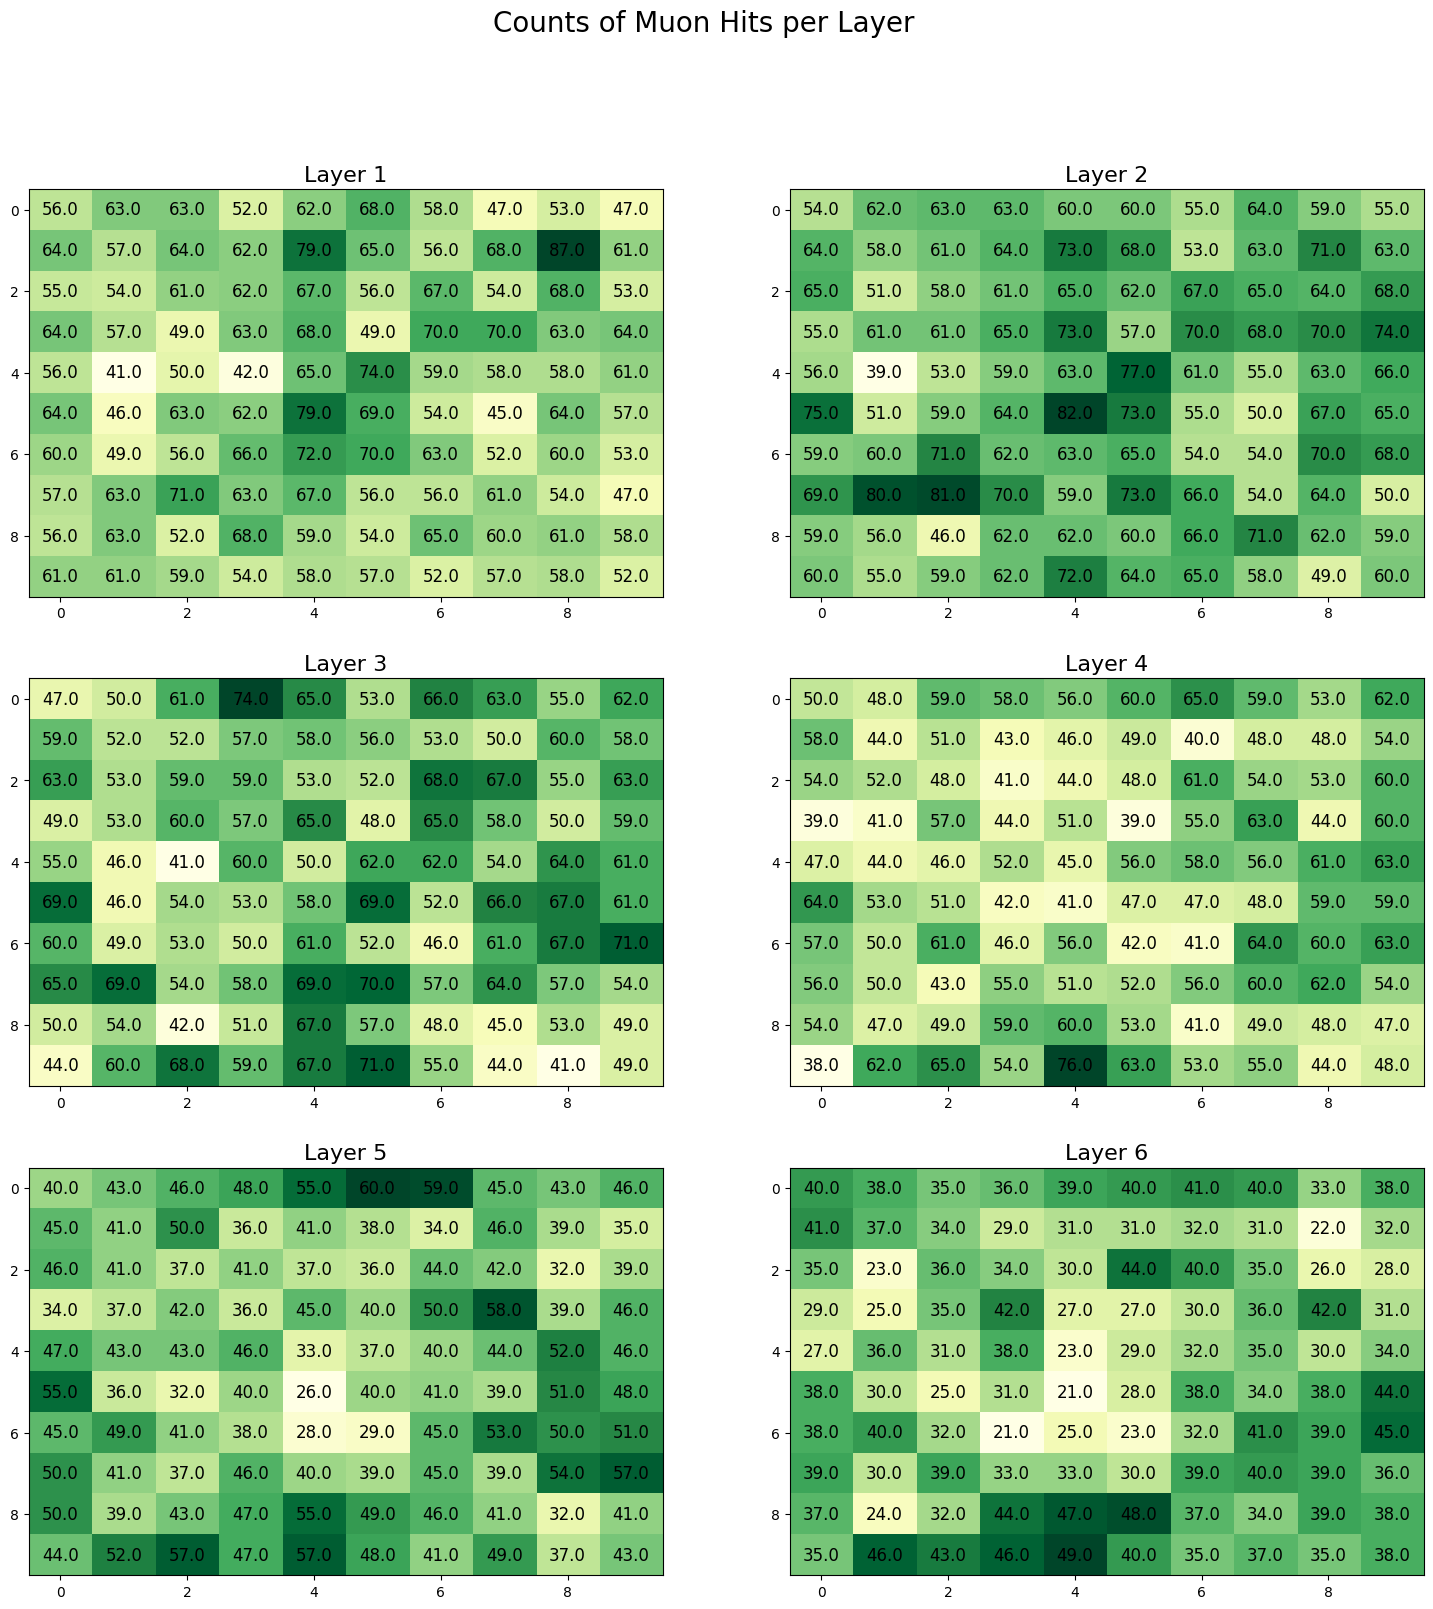

<Figure size 640x480 with 0 Axes>

In [24]:
plot_muon_hits_count(em_reconstruct_geant4.M)